<a href="https://colab.research.google.com/github/RuslanGaliullin/iad-deep-learning/blob/master/hw_2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.

Good luck & have fun! :)

In [1]:

!pip install wandb
!pip3 install pytorch_lightning torchmetrics
!pip install lightning torchvision
!pip3 install matplotlib
!pip3 install numpy

**✨ Внимание ✨**

В этом домашнем задании предлагается использовать библиотеку `pytorch_lightning`. Доступ к ее [документации](https://lightning.ai/docs/pytorch/stable/) заблокирован с территории РФ. Вы можете:

1. Получить к ней доступ с помощью VPN.

2. Собрать документацию самостоятельно. Для этого склонируйте [github-репозиторий](https://github.com/Lightning-AI/lightning/tree/master), запустите в нем терминал (на windows – git bash) и выполните команды:

```shell
git submodule update --init --recursive
make docs
```
После этого откройте появившийся файл `docs/build/html/index.html`. Для работы команд в вашем окружении должен быть `pip`. Полная инструкция [по ссылке](https://github.com/Lightning-AI/lightning/tree/master/docs).

3. Гуглить `<error message> pytorch lightning` или `<how to do this> pytorch lightning`. Stack overflow на территории РФ все еще доступен 😉

4. Не пользоваться `pytorch_lightning` и написать цикл обучения модели самостоятельно. Например, по аналогии с функцией `fit` из [семинара 4](https://github.com/hse-ds/iad-deep-learning/blob/master/2023/seminars/04.%20Optim%20%26%20Lightning/04_Optim%26Lightning_solution.ipynb).

In [2]:
# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
import wandb

wandb.login()

wandb: Currently logged in as: rmgaliullin (ruslan_iad). Use `wandb login --relogin` to force relogin


True

In [3]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torch.utils.data as data_utils
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from lightning.pytorch import LightningModule
from torch.nn import functional as F, CrossEntropyLoss
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm

# You may add any imports you need

In [4]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [6]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2023-11-11 17:10:36--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2023-11-11 17:10:37--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd66091018859653f2381c1af70.dl.dropboxusercontent.com/cd/0/get/CHV1MrJDO-q4hrBroaThlk9bHYLviOyRpbOMfCFeFvJhPi6fXxkwxyxPpgS8pQkFpWZz_rargwC_5u5lLPU4zBr9TjbGv1tCrd3Wd5yNgOk1WF_IMSaCK5Qf-LeTNnaIiMeaSr5yftEv3IqetZT2znPa/file?dl=1# [following]
--2023-11-11 17:10:37--  https://ucd66091018859653f2381c1af70.dl.dropboxusercontent.com/cd/0/get/CHV1MrJDO-q4hrBroaThlk9bHYLviOyRpbOMfCFeFvJhPi6fXxkwxyxPpgS8pQkFpWZz_rargwC_5u5lLPU4zBr9TjbGv1tCrd3Wd

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели.
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать:

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [7]:
# Data transforms (normalization & data augmentation)
train_transform = transforms.Compose([#transforms.Resize((128,128)),
                                      transforms.RandomCrop(64, padding=6, padding_mode='reflect'),
                         transforms.RandomHorizontalFlip(),
                         # transforms.RandomRotate,
                         # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         transforms.ToTensor(),
                         transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose([#transforms.Resize((128,128)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

indices = torch.arange(100000)

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)

sub_train_dataset = data_utils.Subset(train_dataset, indices)

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=2
)
val_dataloader = DataLoader(val_dataset, batch_size=256, num_workers=2)

In [8]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

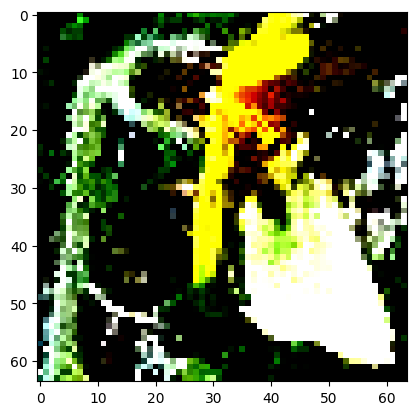

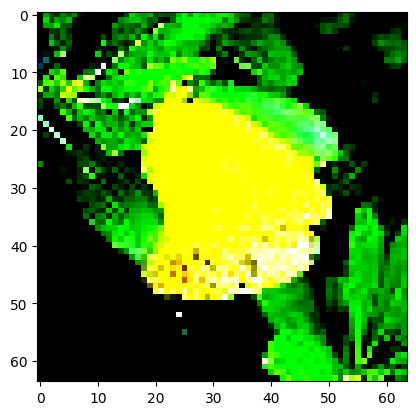

In [9]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

## Задание 1.

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную) + Гипперпараметры

In [10]:
LR = 0.001
EPOCHS = 16

class SimpleNet(torch.nn.Module):
    def __init__(self, num_classes, dropout=0.4):
        super().__init__()
        self.num_classes = num_classes
        self.batch_norm1 = torch.nn.BatchNorm2d(3)

        self.relu = torch.nn.ReLU()

        self.maxpool = torch.nn.MaxPool2d(kernel_size=2, padding=1)

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, padding='same', out_channels=200, kernel_size=3),
            self.relu,
            self.maxpool,
        )
        self.batch_norm2 = torch.nn.BatchNorm2d(200)

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=200, padding='same', out_channels=200, kernel_size=3),
            self.relu,
            self.maxpool,
        )
        self.batch_norm3 = torch.nn.BatchNorm2d(200)

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=200, padding='same', out_channels=200, kernel_size=3),
            self.relu,
            self.maxpool,
        )

        self.batch_norm4 = torch.nn.BatchNorm2d(200)

        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=200, padding='same', out_channels=260, kernel_size=3),
            self.relu,
            self.maxpool,
        )

        self.batch_norm5 = torch.nn.BatchNorm2d(260)

        self.conv5 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=260, padding='same', out_channels=200, kernel_size=3),
            self.relu,
            self.maxpool,
        )


        self.linear1 = torch.nn.Linear(in_features=1800, out_features=1024)

        self.linear2 = torch.nn.Linear(in_features=1024, out_features=1000)

        self.output = torch.nn.Linear(in_features=1000, out_features=self.num_classes)

        self.dropout = torch.nn.Dropout(p=dropout)

        # --------------
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        x = self.batch_norm1(x)
        x = self.conv1(x)

        x = self.batch_norm2(x)
        x = self.conv2(x)

        x = self.batch_norm3(x)
        x = self.conv3(x)

        x = self.batch_norm4(x)
        x = self.conv4(x)

        x = self.batch_norm5(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))

        return self.output(x)

    def forward(self, images, target=None):
        output = self._forward(images)
        # get accuracy score and save it to self.accuracy
        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long(), task='multiclass', num_classes=self.num_classes)

        return loss if target is not None else output

    def get_accuracy(self, reset=False):
        # return accuracy by all values till now
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

### Тренировочный класс lightning

Все совпадения в первом задании взяты с [семинара](https://www.youtube.com/watch?v=SUD61tPKodA&list=PLEwK9wdS5g0oT34oRghcV-jqKq-DEBlzc&index=34&t=222s). И отсюда [logger wandb](https://docs.wandb.ai/guides/integrations/lightning)

In [11]:
class YourModule(LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.lr = learning_rate

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x):
        result = self.model(x)
        return result

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        loss = self.model(images, target)

        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        loss = self.model(images, target)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', self.model.accuracy, prog_bar=True)
        return loss


In [12]:
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
wandb.init(project="hw_02_task_01")

In [13]:
model = SimpleNet(200).to(device)
module = YourModule(model, LR)

In [14]:
from lightning.pytorch.callbacks import LearningRateFinder
from lightning.pytorch import Trainer

class FineTuneLearningRateFinder(LearningRateFinder):
    def __init__(self, milestones, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.milestones = milestones

    def on_fit_start(self, *args, **kwargs):
        return

    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch in self.milestones or trainer.current_epoch == 0:
            self.lr_find(trainer, pl_module)

trainer = Trainer(accelerator="gpu", logger=wandb_logger, max_epochs=EPOCHS) #callbacks=[FineTuneLearningRateFinder(milestones=(5, 10), num_training_steps=200)])
trainer.fit(module, train_dataloader, val_dataloader)
wandb.finish()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type      | Params
------------------------------------
0 | model | SimpleNet | 4

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_loss,█▇▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▂▂▂▂▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_accuracy,▁▂▃▄▅▅▆▆▆▇▇▇███
val_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁
epoch,15
train_loss,2.02108
trainer/global_step,3049
val_accuracy,0.34583
val_loss,2.3911


### Валидация результатов задания

In [ ]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            loss = model(images, labels)
            acc_batch = model.get_accuracy(reset=True)
        accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    return accuracy

In [17]:
accuracy_result = evaluate_task(model, val_dataloader, device)
print(f"\nAccuracy: {accuracy_result}")
print(f"Оценка за это задание составит {np.clip(10 * accuracy_result / 0.44, 0, 10):.2f} баллов")


100%|██████████| 40/40 [00:11<00:00,  3.48it/s]


Accuracy: 0.44023436307907104
Оценка за это задание составит 10.00 баллов


1. Чисто запустить:
  - lr = 0.01
  - epochs = 1
  - optimaizer - Adam
  - model - GoogleNet
  - Result: Оценка 0.38 баллов, train/val_loss = 4.94

Мысли: ура работает

2. Много эпох:
  - Изменение в параметрах:
    - epochs = 10
  - Result: Оценка 5.49 баллов, train/val_loss = 3.2/3.3

Мысли половина готово, но недостаточно и мб больше эпох не надо

3. Добавил в аугментацию RandomVerticalFlip
  - модель взял resnet50
  - батч в трейне сделал равный 32
  - Result: Оценка 3.14 баллов, train/val_loss = 3.9/3.27

Мысли: думаю из-за маленького батча плохо училась сделаю 256 и 8 эпох

4. Батч из 256 и 9 эпох
  - Result: Оценка 5.01 баллов, train/val_loss = 3.5/3.5
Мысли: Просто не хватает качества хз что делать

5. Попробуем оптимизатор RMSprop
  Обучение остановил, потому что закончилось гмпу, но кажется более плавное уменьшение ошибки
Мысли потыкаем другие модели на маленьком количестве данных

6. Модель resnet18
  - 3000 объектов для обучения
  - lr = 0.1
  - Result: Оценка 0.77 баллов, train/val_loss = 18

Мысли: увеличивать шаг - не очень, объектов надо побольше и Адам как оптимайзер был лучше

7. Запуск 17
  - Модель resnet18
  - 100000 объектов для обучения
  - lr = 0.001
  - Оптимайзер - Adam
  - эпох так же 9
  - Result: Оценка 8. баллов, train/val_loss = 2.3/2.7

Мысли: кажется это лучшее, попробуем на всех данных обучиться и сделать 10 эпох

8. Запуск 18
  - Модель resnet18
  - Вся выборка для обучения
  - lr = 0.001
  - Оптимайзер - Adam
  - 8 эпох
  - Result: accuracy 0.33, Оценка 7.58. баллов, train/val_loss = 2.46/2.8

Мысли: странно использовали больше данных для обучения, а стало хуже

9. Запуск 21
  - Модель resnet18
  - Вся выборка для обучения
  - lr = 1
  - Оптимайзер - Adam
  - 8 эпох
  - Result: недостаточно данных для обучения мб

10. Запуск 24
  - Модель resnet34
  - 100000 объектов для обучения
  - lr = 0.0001
  - Оптимайзер - Adam
  - 8 эпох
  - Result: еще хуже resnet18 в 17ом запуске

11. Запуск 29
  - Модель mobilenet_v2
  - 100000 объектов для обучения
  - lr = 0.0001
  - Оптимайзер - Adam
  - 8 эпох
  - Result: еще хуже resnet18 в 17ом запуске и даже resnet34

12. Запуск 37
  - Модель resnet18
  - 100000 объектов для обучения
  - lr = 0.00229 (подобрано автоподбором lr)
  - Оптимайзер - Adam
  - 10 эпох
  - Result: еще хуже resnet18 в 17ом запуске

Мысли: не хватило мб шагов нормально подобрать lr
  
13. Запуск 40
  - Модель resnet18
  - вся выборка для обучения
  - lr = 1.1781484060029257e-08 (подобрано автоподбором lr)
  - Оптимайзер - Adam
  - 8 эпох
  - Result: очень маленький шаг, вообще не обучается, итог Accuracy: 0.005142405163496733

Мысли: Возвращаю модель из 17ого запуска и просто делаю больше эпох

14. Запуск 43
  - Модель resnet18
  - вся выборка для обучения
  - lr = 0.001
  - Оптимайзер - Adam
  - 20 эпох
  - Result: Accuracy: 0.36, train/val_loss = 1.8/3.8

Мысли: на трейне лосс уменьшается, но на валидации - нет, даже много эпох не помогает. Кажется есть CIFAR100 датасет с мелкими картинками, попробуем первое решение отсюда взять https://zhenye-na.github.io/blog/2018/10/07/pytorch-resnet-cifar100.html ( не сработало )

15. Запуск 107 победный
  - Модель своя
  - вся выборка для обучения
  - lr = 0.001
  - Оптимайзер - Adam
  - 16 эпох
  - Result: Accuracy: 0.4402, train/val_loss = 1.9/2.3

Мысли: своя модель + аугментация зарешали. Аугментация взята [отсюда](https://jovian.com/truptixkhadye/imagenette-resnet9)


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте предобученную)

In [ ]:
LR = 0.001
EPOCHS = 25

class SimpleNet(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.base_model = torchvision.models.resnet18(weights='DEFAULT')
        self.output = torch.nn.Linear(1000, self.num_classes)

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        x = self.base_model(x)
        return self.output(x)

    def forward(self, images, target=None):
        output = self._forward(images)
        # get accuracy score and save it to self.accuracy
        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long(), task='multiclass', num_classes=self.num_classes)

        return loss if target is not None else output

    def get_accuracy(self, reset=False):
        # return accuracy by all values till now
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

### Тренировочный класс lightning

In [ ]:
class YourModule(LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.lr = learning_rate

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x):
        result = self.model(x)
        return result

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        loss = self.model(images, target)

        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        loss = self.model(images, target)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', self.model.accuracy, prog_bar=True)
        return loss


In [ ]:
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
wandb.init(project="hw_02_task_02", settings=wandb.Settings(start_method="thread"))

model = SimpleNet(200)
module = YourModule(model, LR)

In [ ]:
from lightning.pytorch.callbacks import LearningRateFinder
from lightning.pytorch import Trainer
class FineTuneLearningRateFinder(LearningRateFinder):
    def __init__(self, milestones, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.milestones = milestones

    def on_fit_start(self, *args, **kwargs):
        return

    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch in self.milestones or trainer.current_epoch == 0:
            self.lr_find(trainer, pl_module)

trainer = Trainer(accelerator="gpu", logger=wandb_logger, max_epochs=EPOCHS) #, callbacks=[FineTuneLearningRateFinder(milestones=(5, 10), num_training_steps=10000)])
trainer.fit(module, train_dataloader, val_dataloader)
# wandb.finish()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleNet | 11.9 M
------------------------------------
11.9 M    Trainable params
0         Non-trainable params
11.9 M    Total params
47.559    Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|████████████████████| 196/196 [00:51<00:00,  3.82it/s, v_num=zefj]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 40/40 [00:01<00:00, 24.53it/s]
Epoch 1: 100%|█| 196/196 [01:02<00:00,  3.13it/s, v_num=zefj, val_loss=2.870, va
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 40/40 [00:01<00:00, 23.44it/s]
Epoch 2: 100%|█| 196/196 [01:02<00:00,  3.13it/s, v_num=zefj, val_loss=2.600, va
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 40/40 [00:01<00:00, 23.22it/s]
Epoch 3:  80%|▊| 157/196 [00:52<00:13,  2.98it/s, v_num=zefj, val_loss=2.290, va

### Валидация результатов задания

In [ ]:
accuracy_result = evaluate_task(model, val_dataloader, device)
print(f"\nAccuracy: {accuracy_result}")
print(f"Оценка за это задание составит {np.clip(10 * (accuracy_result - 0.5) / 0.34, 0, 10):.2f} баллов")

# Отчёт об экспериментах

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.